## SOEE3250/SOEE5675M/SOEE5116					

Inverse Theory

# Practical 9: Bayesian inversion using Markov Chain Monte Carlo, based on the Metropolis-Hastings algorithm.

In this practical you will revisit the non-linear problem from Practical 4, the goal of which was to locate an earthquake from P- and S-wave arrival times. In Practical 4, you did not attempt to estimate the depth of the earthquake (only the epicentre), as in fact this would have made the problem ill-posed. In this practical, the algorithm allows you to include depth estimation in your inversion.

## Inverse problem description

The goal is to locate the hypocentre of an earthquake, using the arrival times recorded at 3 seismometers. The locations and arrival times at each seismometer are:

| X-coord (km) |  Y-coord (km) | Z-coord (km) | P-wave arrival | S-wave arrival | 
| :------ |:---------:| :---------: |:---------: |---------:|
|  27.3570  |      -58.2520 | 0.193 | 28.9   |  40.1
|  5.8120  |   77.4070  | 0.233 | 23.8      |    31.3 |
| -33.0670   |   -18.9540  | 0.234 | 29.5   |       41.2

Each arrival time is measured in seconds after the time 14h:32.
Assume that the seismic velocities for both P- and S- waves are constant, but unknown.
The time (in seconds, after 14h:32) of the earthquake is also unknown.

Assume that the measurement errors are Gaussian with a standard deviation of 1 s.

## Mathematical background
You have 6 arrival times (6 data) and six unknowns: $x$,$y$,$z$ of the wave source, the time that the waves are triggered (t0), and the speed of the two types of measured wave (vp, vs). The goal is to estimate the model vector
$$ {\bf m} = (x,y,z,t0,vp,vs)$$
which is nonlinearly related to the data.


In this practical, we will numerically construct the full joint posterior pdf of all the model parameters (i.e. the pdf of the model given the data), by using a **Markov Chain Monte Carlo** method, based on the **Metropolis-Hastings** algorithm. Recall that the posterior is the product of the prior and the likelihood. We will further assume that all parameters are independent.

## Prior information
The prior information (our initial beliefs about the model parameters) are that 
- $x$, $y$ are uniformly distributed in the interval [-100,100] (km).
- $z$ is uniformly distributed in the interval [-100,0] (km)
- $t0$ is uniformly distributed in the interval $[0, 100]$(s) and 
- Vp, Vs are distributed uniformly in the interval [0.1,10] (km/s).

## Likelihood
The likelihood is proportional to $e^{-S^2}$, with
$$  S^2 = \frac{1}{2} \sum_i \left[ {\bf d}-{\bf g}({\bf m})\right]_i^2 $$ because all the errors are assumed 1 s.

## Algorithm
The overall Metropolis-Hastings algorithm is:
- Initialise the chain with a "current model" 
- Produce a trial model vector based on a perturbation to the current model
- Calculate the trial model’s posterior probability: trial_posterior_prob
- Calculate the ratio $p =$ trial_posterior_prob/posterior_prob, where posterior_prob is the posterior probability of the current model. Computationally, we compute $log(p) = $log(trial_posterior_prob) - log(posterior_prob) as both probabilities may be very small (and taking the quotient of small numbers may produce significant errors)
- Check to see if the model has a non-zero prior probability by checking it lies within the defined boundaries. If it does have a non-zero prior probability then: 
    -  If $p>1$ then accept the proposed model
    -  If $p<1$ then accept the proposed model with probability $p$
    -  Otherwise discard the perturbed model and keep the current model
- Save the current model
- Iterate 

Note that this procedure replies upon only the ratio of the posterior probabilities, so any normalizing factor (in the posterior probability) need never be calculated.

In this practical, we will produce a perturbed model by adding a uniformly distributed value 
- for x,y,z in the range [-5,5]
- for t0 in the range [-2,2]
- for Vp, Vs in the range [-1,1]



In [1]:
import matplotlib.pyplot as plt
import numpy as np
# The data vector is 
d = np.array([28.9, 23.8, 29.5, 40.1, 31.3, 41.2])

Q1) Complete the forward model function that takes a column vector of model parameters (m_trial) and returns a column vector of predicted measurements (d_hat). 
Check that the model vector $[0,0,0,0,3,4]$  produces the arrival times 
$[21.4521,   25.8751,  12.7049,   16.0891,   19.4063,    9.5287]$



In [2]:
def g_calculate(m):
    """Function that calculates g for given model m = (x,y,z,t0,vp,vs)"""
    g = np.zeros(6)
    xseis = np.array([27.3570, 5.8120, -33.0670])
    yseis = np.array([-58.2520, 77.4070, -18.9540])
    zseis = np.array([0.193, 0.233, 0.234])
    g[0] = m[3] + 1.0/m[4] * np.sqrt( (xseis[0]-m[0])**2+(yseis[0]-m[1])**2+(zseis[0]-m[2])**2)
    
    return g

In [3]:
def g_calculate(m):
    """Function that calculates g for given model m = (x,y,z,t0,vp,vs)"""
    g = np.zeros(6)
    xseis = np.array([27.3570, 5.8120, -33.0670])
    yseis = np.array([-58.2520, 77.4070, -18.9540])
    zseis = np.array([0.193, 0.233, 0.234])
    g[0] = m[3] + 1.0/m[4] * np.sqrt( (xseis[0]-m[0])**2+(yseis[0]-m[1])**2+(zseis[0]-m[2])**2)
    g[1] = m[3] + 1.0/m[4] * np.sqrt( (xseis[1]-m[0])**2+(yseis[1]-m[1])**2+(zseis[1]-m[2])**2)
    g[2] = m[3] + 1.0/m[4] * np.sqrt( (xseis[2]-m[0])**2+(yseis[2]-m[1])**2+(zseis[2]-m[2])**2)
    g[3] = m[3] + 1.0/m[5] * np.sqrt( (xseis[0]-m[0])**2+(yseis[0]-m[1])**2+(zseis[0]-m[2])**2)
    g[4] = m[3] + 1.0/m[5] * np.sqrt( (xseis[1]-m[0])**2+(yseis[1]-m[1])**2+(zseis[1]-m[2])**2)
    g[5] = m[3] + 1.0/m[5] * np.sqrt( (xseis[2]-m[0])**2+(yseis[2]-m[1])**2+(zseis[2]-m[2])**2)
    return g


In [4]:
g_calculate( [0,0,0,0,3,4])

array([21.45211257, 25.87507871, 12.70492189, 16.08908442, 19.40630903,
        9.52869141])

Q2) Complete the code below

In [16]:
number_iterations=10000  # number of iterations.
np.random.seed(seed=10)
M = 6
models_saved=np.zeros((number_iterations,M))
log_likelihood_saved=np.zeros((number_iterations,1))
n_accept = 0 # number of accepted models
n_reject = 0 # number of rejected models
m_current = np.array([0,0,0,0,3.0,2])  #initial model

for i in range(number_iterations):

# Propose a model
    m_trial = m_current.copy()                
    m_trial[0:3]= m_trial[0:3] + np.random.uniform(low=-5,high=5,size=3)
    m_trial[3]= m_trial[3] + np.random.uniform(low=-2,high=2,size=1)
    m_trial[4:6]= m_trial[4:6] + np.random.uniform(low=-1,high=1,size=2)
    
# calculate the ratio of the likelihoods
    Arrival_times_trial = g_calculate(m_trial);
    r=d-Arrival_times_trial  # residuals
    log_likelihood_trial=-np.sum(r**2)/2.0  #likelihood is proportional to exp of this.

    Arrival_times_for_current_model = g_calculate(m_current);
    r=d-Arrival_times_for_current_model #residuals
    log_likelihood_current=-np.sum(r**2)/2.0

    ratio_likelihoods = log_likelihood_trial - log_likelihood_current


    # check to see if the trial model lies within the allowable bounds of the uniform priors

    if ((m_trial[0] < -100) | (m_trial[0] > 100) | (m_trial[1] < -100) | (m_trial[1] > 100) | 
        (m_trial[2] < -100) | (m_trial[2] > 0) | (m_trial[3] < 0) | (m_trial[3] > 100) |
        (m_trial[4] < 0.1) | (m_trial[4] > 10) | (m_trial[5] < 0.1) | (m_trial[5] > 10)):
        # do nothing: model lies outside the prior distribution so has probability zero
        n_reject += 1
    else:
        if np.exp(ratio_likelihoods) > np.random.uniform(low=0, high=1,size=1):
            m_current=m_trial
            n_accept += 1
        else:
            n_reject += 1
    models_saved[i,:]=m_current
    log_likelihood_saved[i] = log_likelihood_current



Q3) Make a plot of the trajectory of the x-y values of the models in a 2D plot for the first 5000 iterations in red.
Plot the remaining values in blue. The red models are "burn-in" and should be discarded.

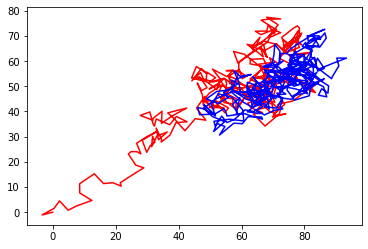

In [17]:
plt.figure()
plt.plot(models_saved[:5000,0],models_saved[:5000,1],'r')
plt.plot(models_saved[5000:,0],models_saved[5000:,1],'b')

Q4) Complete the code to produce a 2x3 grid of histograms showing the pdf for each model parameter separately. 
These are the marginal distributions.

How do the distributions compare to the priors? That is, how have the data refined your initial beliefs about the model?

Text(0.5, 1.0, 'Vs')

<Figure size 432x288 with 0 Axes>

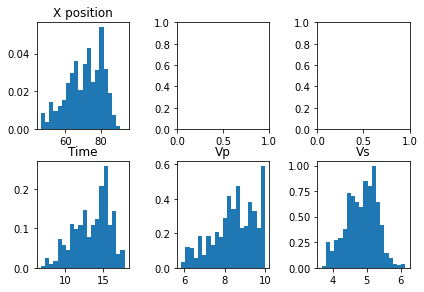

In [18]:
plt.figure( )
fig, axs = plt.subplots(2,3)
plt.tight_layout()
burn_in = 5000
axs[0,0].hist(models_saved[burn_in:,0], bins=20, density=True)
axs[0,0].set_title('X position')

axs[1,0].hist(models_saved[burn_in:,3], bins=20, density=True)
axs[1,1].hist(models_saved[burn_in:,4], bins=20, density=True)
axs[1,2].hist(models_saved[burn_in:,5], bins=20, density=True)
axs[1,0].set_title('Time')
axs[1,1].set_title('Vp')
axs[1,2].set_title('Vs')


Text(0.5, 1.0, 'Vs')

<Figure size 432x288 with 0 Axes>

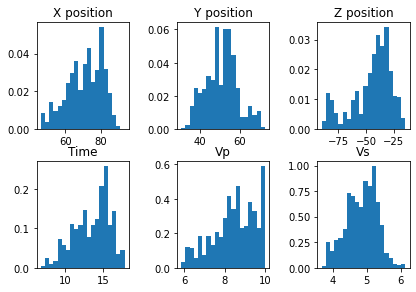

In [19]:
plt.figure( )
fig, axs = plt.subplots(2,3)
plt.tight_layout()
burn_in = 5000
axs[0,0].hist(models_saved[burn_in:,0], bins=20, density=True)
axs[0,1].hist(models_saved[burn_in:,1], bins=20, density=True)
axs[0,2].hist(models_saved[burn_in:,2], bins=20, density=True)
axs[0,0].set_title('X position')
axs[0,1].set_title('Y position')
axs[0,2].set_title('Z position')

axs[1,0].hist(models_saved[burn_in:,3], bins=20, density=True)
axs[1,1].hist(models_saved[burn_in:,4], bins=20, density=True)
axs[1,2].hist(models_saved[burn_in:,5], bins=20, density=True)
axs[1,0].set_title('Time')
axs[1,1].set_title('Vp')
axs[1,2].set_title('Vs')


Q5) Calculate the mean, standard deviation, and 95% credible intervals for the positions $x,y,z$.

Calculate the credible interval by arranging all the models in order (based on the values of $x$, for example), and inspecting the values at 2.5% from either end. One example is done for you.

In [20]:
models_saved[burn_in:,:] #remove the burn_in models
number_iterations = models_saved.shape[0]
I = np.argsort(models_saved[:,0])
n1 = round(number_iterations*2.5/100)
n2 = round(number_iterations*97.5/100)
print('95% credible interval for x is [{0:f}, {1:f}]'.format(float(models_saved[I[n1],0]), float(models_saved[I[n2],0])))

95% credible interval for x is [48.731041, 86.040545]


In [22]:
print('Mean, standard deviation of x is {0:f}, {1:f}'.format(np.mean(models_saved[:,0]), np.std(models_saved[:,0])))
print('Mean, standard deviation of y is {0:f}, {1:f}'.format(np.mean(models_saved[:,1]), np.std(models_saved[:,1])))                                                                                  
print('Mean, standard deviation of z is {0:f}, {1:f}'.format(np.mean(models_saved[:,2]), np.std(models_saved[:,2])))                                                                                  

I = np.argsort(models_saved[:,0])
n1 = round(number_iterations*2.5/100)
n2 = round(number_iterations*97.5/100)
print('95% credible interval for x is [{0:f}, {1:f}]'.format(float(models_saved[I[n1],0]), float(models_saved[I[n2],0])))

I = np.argsort(models_saved[:,1])
print('95% credible interval for y is [{0:f}, {1:f}]'.format(float(models_saved[I[n1],1]), float(models_saved[I[n2],1])))

I = np.argsort(models_saved[:,2])
print('95% credible interval for z is [{0:f}, {1:f}]'.format(float(models_saved[I[n1],2]), float(models_saved[I[n2],2])))


Mean, standard deviation of x is 71.078771, 9.892097
Mean, standard deviation of y is 50.898655, 7.964096
Mean, standard deviation of z is -44.861443, 17.687904
95% credible interval for x is [48.731041, 86.040545]
95% credible interval for y is [36.943186, 68.594692]
95% credible interval for z is [-85.754808, -20.509103]


Q6) How do the values obtained by the nonlinear descent in practical 4 compare?

The values found in practical 4 were $x = 49.57, y = 32.70$, which lie about 2 standard deviation from the mean in both cases. This means that the model parameters are not very likely - however remember that the model in practical 4 was 2D only: here the model is 3D so we would expect significant differences.

Q7) What is the fraction of the accepted models? If the perturbations are chosen well, this should be around 10-40%

In [24]:
# This is the number of accepted models including the burn in period:

number_iterations = 10000
print('Fraction of accepted perturbed models is {0:1.1f}%'.format(n_accept/number_iterations*100))

Fraction of accepted perturbed models is 6.7%


Q8) Increase the number of iterations. Are your answers converged?

Q9) Try changing the uniform distributions defining the perturbations. Do you answers change?